In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [121]:
# Load dataset
file_path = "household_power_consumption/household_power_consumption.txt"  # Update with your actual path
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])

In [122]:
#  Convert Date & Time to Datetime Format
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])  # Drop original columns
df = df.set_index('datetime')  # Set datetime as index
df = df.astype(float)  # Convert all columns to float

In [123]:
df_resampled = df.resample('W').mean()  # Aggregates to weekly average
df_resampled = df_resampled.interpolate() # interpolate missing values

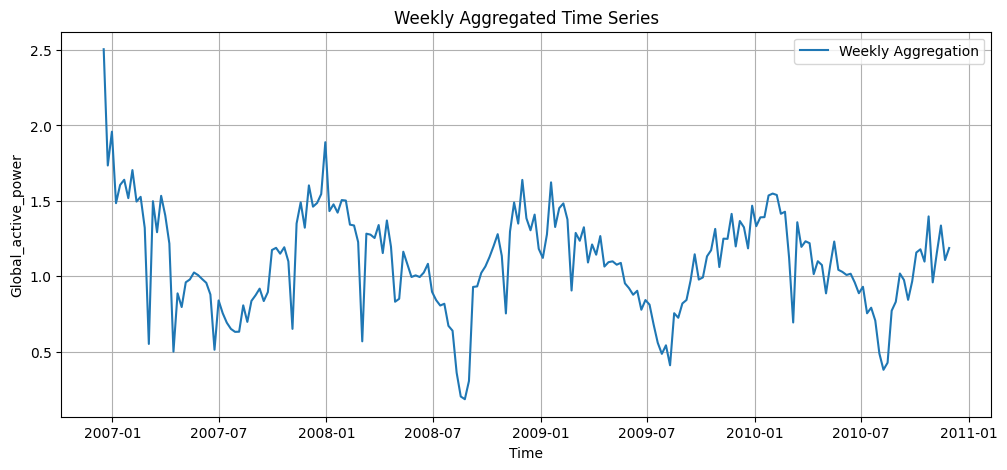

In [124]:

def plot_aggregated_time_series(df, freq, value_column='Global_active_power'):
    """
    Aggregates time series data and plots it based on the given frequency.

    Parameters:
    - df: Pandas DataFrame with a DateTime index.
    - freq: Resampling frequency ('H', 'D', 'W', 'M', 'Y' for hourly, daily, weekly, monthly, yearly).
    - value_column: The column to aggregate and plot.

    Returns:
    - A time series plot of the aggregated data.
    """
    # Define frequency labels for the title
    freq_labels = {
        'h': 'Hourly',
        'd': 'Daily',
        'W': 'Weekly',
        'ME': 'Monthly',
        'YE': 'Yearly'
    }

    # if freq not in freq_labels:
    #     raise ValueError("Invalid frequency. Use 'h' (hourly), 'D' (daily), 'W' (weekly), 'ME' (monthly), or 'YE' (yearly).")

    # Resample (aggregate) data
    df_temp = df.resample(freq)[value_column].mean()

    # Plot the resampled time series
    plt.figure(figsize=(12, 5))
    plt.plot(df_temp, label=f'{freq_labels[freq]} Aggregation')
    # plt.plot(df_resampled.index, df_resampled['Global_active_power'], label=f'{freq_labels[freq]} Aggregation')
    plt.xlabel('Time')
    plt.ylabel(value_column)
    plt.title(f'{freq_labels[freq]} Aggregated Time Series')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_aggregated_time_series(df, 'W')  # Weekly

## Feature Scaling

In [125]:
# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the 'Global_active_power' column
df_scaled = scaler.fit_transform(df_resampled[['Global_active_power']])


## Creating sequencing for training

In [126]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Take the past 'time_steps' values
        y.append(data[i+time_steps])  # Predict the next value
    return np.array(X), np.array(y)

# Set the number of past time steps to use
time_steps = 70  

# Create sequences
X, y = create_sequences(df_scaled, time_steps)


## Modelling and training

In [127]:
# Define train-test split
split = int(0.8 * len(X))  # 80% training data

# Split into train and test sets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (109, 70, 1), Test shape: (28, 70, 1)


In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

# Build LSTM model
# model = Sequential([
#     LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
#     Dropout(0.2),  # Regularization
#     LSTM(units=50, return_sequences=False),  # Second LSTM layer
#     Dropout(0.2),  # Regularization
#     Dense(units=1)  # Output layer
# ])


model = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1))),  # BiLSTM
    Dropout(0.1),  # Lower dropout to retain more complexity
    LSTM(units=100, return_sequences=True),  # Second LSTM layer
    Dropout(0.1),
    LSTM(units=100, return_sequences=False),  # Third LSTM layer
    Dense(units=50, activation='relu'),  # Extra Dense layer
    Dense(units=1)  # Output layer
])

# model = Sequential([
#     LSTM(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
#     LSTM(units=32, activation='relu', return_sequences=False),  # Second LSTM layer
#     Dropout(0.2),  # Regularization
#     Dense(units=1)  # Output layer
# ])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()


c:\Users\ihebe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [129]:
# Train the model
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,  # Increase epochs to allow better learning
    batch_size=32,  # Keep a reasonable batch size
    # validation_data=(X_val, y_val),  # Use a validation set to monitor performance
    callbacks=[early_stopping],  # Stop training when val_loss stops improving
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1208
Epoch 2/100
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0560

c:\Users\ihebe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0450
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0283
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0159
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0168
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0170
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0117
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0143
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0139
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0120
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0115
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0099
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0091
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0082
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0075
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0081
Epoch 17/100
4/4 ━━━━━━━━━━━━━

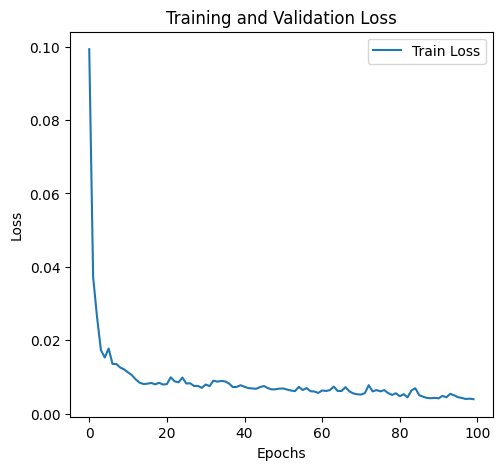

In [130]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot (if available)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

plt.show()


In [131]:
# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - loss: 0.0057
Test Loss (MSE): 0.00572948856279254


In [132]:
# Predict on test set
y_pred = model.predict(X_test)

# Inverse transform predictions to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [133]:
# Compute MAE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.1258
Root Mean Squared Error (RMSE): 0.1757


## Visualize results on the test set

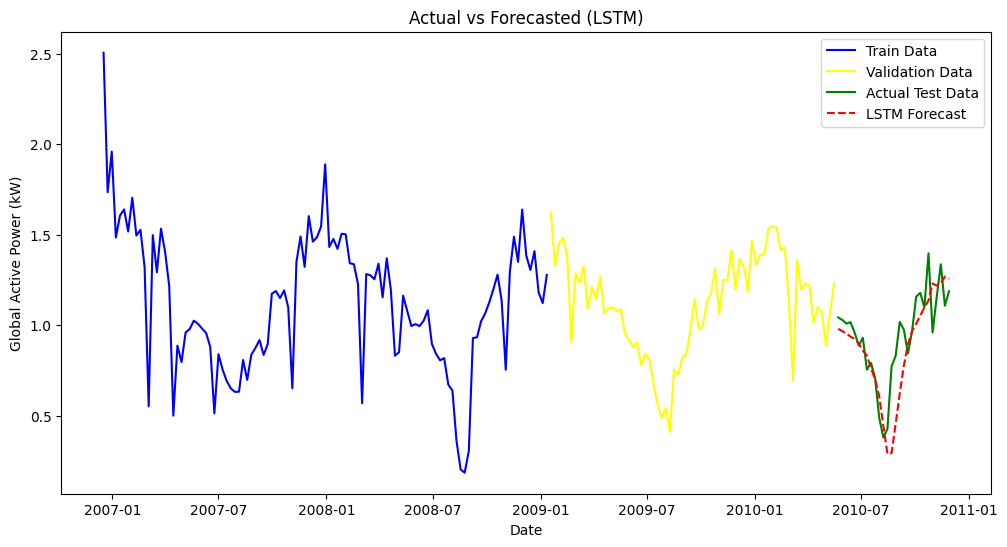

In [134]:
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(df_resampled.index[:split], scaler.inverse_transform(df_scaled[:split]), 
         label="Train Data", color="blue")

# Plot validation data
plt.plot(df_resampled.index[split:split+ time_steps], scaler.inverse_transform(df_scaled[split:split+ time_steps]), 
         label="Validation Data", color="yellow")

# Plot actual test data
plt.plot(df_resampled.index[split + time_steps:], y_test_inv, 
         label="Actual Test Data", color="green")

# Plot LSTM forecast (predictions)
plt.plot(df_resampled.index[split + time_steps:], y_pred_inv, 
         label="LSTM Forecast", color="red", linestyle="dashed")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Actual vs Forecasted (LSTM)")
plt.legend()
plt.show()

